In [40]:
from finn.transformation.general import GiveUniqueNodeNames
model = ModelWrapper("/tmp/test_partition1_hls.onnx")
model = model.transform(GiveUniqueNodeNames())
model.save("/tmp/test_folding_partition1.onnx")


In [187]:
### Function that returns
# 1) fork_nodes: nested dictionary of fork nodes:
# {key1: {key2: value2, key3: value3}, ...}
# key1 indicates which block index we are considering (i.e. which fork structure).
# key2/key3 indicate the two lanes within a fork

# 2) non_fork_nodes: dictionary of non_fork nodes:
# {key1: value1, key2: value2}
# Each key represents a block index and the values are the nodes within that block structure

from finn.core.modelwrapper import ModelWrapper

model = ModelWrapper("/tmp/test_folding_partition1.onnx")
fork_nodes = {}
non_fork_nodes = {}
part_id = 0
in_fork = False

def find_upstream_fork(x):
    is_fork = model.is_fork_node(x)
    return is_fork

def find_upstream_nodes(x):
    """ Given a tensor name x, it returns the upstream function names. """ 
    upstream_nodes = model.find_upstream(x, find_upstream_fork)
    upstream_node_names = list(map(lambda x: x.name, upstream_nodes))
    return np.flip(upstream_node_names[:-1])
    
def compare_upstream(x, y):
    """ 
    Given two sequences of upstream nodes, either a list or single element, it returns whether they are equals.
    It checks whether y is in x, where y can be either a string of list of strings.
    """
    if isinstance(y, str): #
        return y in x
    else:
        return [el in x for el in y].all()
    
for n in model.graph.node:
    is_fork = model.is_fork_node(n)
    is_join = model.is_join_node(n)
    
    if is_fork:
        in_fork = True
        if part_id in non_fork_nodes:
            non_fork_nodes[part_id].append(n.name)
        else:
            non_fork_nodes[part_id] = []
            non_fork_nodes[part_id].append(n.name)
        part_id+=1
        
        fork_nodes[part_id] = {}
        for lane, tensor_name in enumerate(n.output):
            cons = model.find_consumer(tensor_name)
            fork_nodes[part_id][lane] = [cons.name]
        continue
    elif is_join:
        in_fork = False
        part_id+=1
    
    
    if in_fork:
        in_dict = np.any([n.name in v for v in fork_nodes[part_id].values()])
        if in_dict:
                continue
        else:
            upstream_nodes = find_upstream_nodes(n.input[0])
            for k,v in fork_nodes[part_id].items():
                upstream_nodes_match = (upstream_nodes==v).all()
                if upstream_nodes_match:
                    fork_nodes[part_id][k].append(n.name)
                    
    elif part_id in non_fork_nodes:
        non_fork_nodes[part_id].append(n.name)
    else:
        non_fork_nodes[part_id] = []
        non_fork_nodes[part_id].append(n.name)
            

In [188]:
print(fork_nodes)

{1: {0: ['FMPadding_Batch_0', 'ConvolutionInputGenerator1D_0', 'Vector_Vector_Activate_Batch_0', 'StreamingFCLayer_Batch_1', 'FMPadding_Batch_1', 'ConvolutionInputGenerator1D_1', 'Vector_Vector_Activate_Batch_1', 'StreamingFCLayer_Batch_2', 'FMPadding_Batch_2', 'ConvolutionInputGenerator1D_2', 'Vector_Vector_Activate_Batch_2', 'StreamingFCLayer_Batch_3', 'FMPadding_Batch_3', 'ConvolutionInputGenerator1D_3', 'Vector_Vector_Activate_Batch_3', 'StreamingFCLayer_Batch_4', 'FMPadding_Batch_4', 'ConvolutionInputGenerator1D_4', 'Vector_Vector_Activate_Batch_4', 'StreamingFCLayer_Batch_5'], 1: ['StreamingFCLayer_Batch_0']}, 3: {0: ['FMPadding_Batch_5', 'ConvolutionInputGenerator1D_5', 'Vector_Vector_Activate_Batch_5', 'StreamingFCLayer_Batch_7', 'FMPadding_Batch_6', 'ConvolutionInputGenerator1D_6', 'Vector_Vector_Activate_Batch_6', 'StreamingFCLayer_Batch_8', 'FMPadding_Batch_7', 'ConvolutionInputGenerator1D_7', 'Vector_Vector_Activate_Batch_7', 'StreamingFCLayer_Batch_9', 'FMPadding_Batch_8',

In [189]:
print(non_fork_nodes)

{0: ['Thresholding_Batch_0', 'DuplicateStreams_Batch_0'], 2: ['AddStreams_Batch_0', 'Thresholding_Batch_1', 'DuplicateStreams_Batch_1'], 4: ['AddStreams_Batch_1', 'Thresholding_Batch_2', 'DuplicateStreams_Batch_2'], 6: ['AddStreams_Batch_2']}


In [ ]:
###

In [24]:
from finn.core.modelwrapper import ModelWrapper
from finn.analysis.fpgadataflow.exp_cycles_per_layer import exp_cycles_per_layer
from finn.transformation.general import GiveUniqueNodeNames
from finn.util.basic import get_by_name
from finn.custom_op.registry import getCustomOp

model = ModelWrapper("/tmp/test_partition1_hls.onnx")
model = model.transform(GiveUniqueNodeNames())

for n in model.graph.node:
    if n.op_type=="StreamingFCLayer_Batch":
        inst = getCustomOp(n)
        mh = get_by_name(n.attribute, "MH", "name").i
        mw = get_by_name(n.attribute, "MW", "name").i
        inst.set_nodeattr("PE", mh)
        inst.set_nodeattr("SIMD", mw)
    if n.op_type=="Thresholding_Batch":
        ifc = get_by_name(n.attribute, "NumChannels", "name").i
        inst.set_nodeattr("PE", ifc)
    if n.op_type=="AddStreams_Batch":
        ifc = get_by_name(n.attribute, "NumChannels", "name").i
        inst.set_nodeattr("PE", ifc)
    if n.op_type=="DuplicateStreams_Batch":
        ifc = get_by_name(n.attribute, "NumChannels", "name").i
        inst.set_nodeattr("PE", ifc)
        

exp_cycles_dict = model.analysis(exp_cycles_per_layer)



In [25]:
for n in model.graph.node:
    if n.op_type=="StreamingFCLayer_Batch":
        print(n)
        break

input: "4SupjH"
input: "Conv_3_param0"
input: "MultiThreshold_12_param0"
output: "RtacQC"
name: "StreamingFCLayer_Batch_0"
op_type: "StreamingFCLayer_Batch"
attribute {
  name: "ActVal"
  i: 0
  type: INT
}
attribute {
  name: "MH"
  i: 256
  type: INT
}
attribute {
  name: "MW"
  i: 256
  type: INT
}
attribute {
  name: "PE"
  i: 256
  type: INT
}
attribute {
  name: "SIMD"
  i: 256
  type: INT
}
attribute {
  name: "backend"
  s: "fpgadataflow"
  type: STRING
}
attribute {
  name: "binaryXnorMode"
  i: 0
  type: INT
}
attribute {
  name: "inputDataType"
  s: "UINT8"
  type: STRING
}
attribute {
  name: "mem_mode"
  s: "const"
  type: STRING
}
attribute {
  name: "noActivation"
  i: 0
  type: INT
}
attribute {
  name: "numInputVectors"
  ints: 1
  ints: 128
  ints: 1
  type: INTS
}
attribute {
  name: "outputDataType"
  s: "UINT4"
  type: STRING
}
attribute {
  name: "weightDataType"
  s: "INT4"
  type: STRING
}
attribute {
  name: "accDataType"
  s: "INT20"
  type: STRING
}
domain: "

In [26]:
import csv

with open('dict.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in exp_cycles_dict.items():
       writer.writerow([key, value])

<BarContainer object of 72 artists>

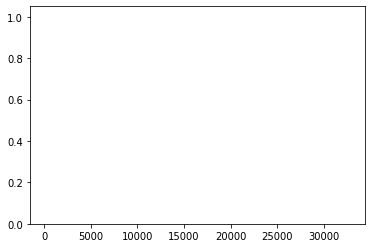

In [21]:
import matplotlib.pyplot as plt

x = []
y = []
for k,v in exp_cycles_dict.items():
    x.append(k)
    y.append(v)

plt.bar(y, 1)
    
